In [2]:
from fastai.vision.all import *

In [3]:
PATH = Path('../input/optiver-realized-volatility-prediction')

# data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

# sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
# for sz in sizes:
#     data_df[sz] = data_df[sz]/ 1_000_000



In [27]:
#train_df = pd.read_csv(PATH/'train_with_offset.csv')
# data_df['wap'] = (data_df.bid_price1 * data_df.ask_size1 + data_df.ask_price1 * data_df.bid_size1) / (data_df.ask_size1 + data_df.bid_size1)

# mean_wap =[]
# for row in train_df.itertuples():
#     df = data_df.iloc[row.offset:row.offset+600]
#     mean_wap.append(df.wap.mean())

In [28]:
# train_df['mean_wap']=mean_wap
# train_df.to_csv(PATH/'train_with_wap.csv')

In [29]:
# np_data = data_df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()

# del data_df

# np_data = np_data.astype('float32')
# torch_data = torch.tensor(np_data)

# del np_data

# torch.save(torch_data, PATH/'torch_data.pth')

In [4]:
%%time
torch_data = torch.load(PATH/'torch_data.pth')

CPU times: user 0 ns, sys: 11.2 s, total: 11.2 s
Wall time: 2min 2s


In [31]:
#torch_data[:,[2,3,6,7]] = 1000000 * torch_data[:,[2,3,6,7]] 

In [5]:
means, stds = torch_data.mean(dim=0), torch_data.std(dim=0)
print(means, stds)
torch_data = (torch_data - means) / stds

tensor([9.9968e-01, 1.0003e+00, 7.6999e-04, 7.6673e-04, 9.9948e-01, 1.0005e+00,
        9.5934e-04, 9.2822e-04]) tensor([0.0037, 0.0037, 0.0054, 0.0050, 0.0037, 0.0037, 0.0067, 0.0057])


In [6]:
train_df = pd.read_csv(PATH/'train_with_wap.csv')

In [7]:
w = train_df.mean_wap.to_numpy()

w =np.sort(w)

bins = []

step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 2)
    print(w[i], w[j-1],np.median(w[i:j]) )

wap_bin = np.digitize(train_df.mean_wap, bins)

train_df['wap_bin']=wap_bin

0.9172531180048944 0.9971951138775056 0.9956492523836432
0.9971951327900604 0.9984703256953886 0.9979708959569917
0.9984703751656142 0.9991431543863876 0.9988451162091514
0.9991431683337992 0.999616836138266 0.9993924853218963
0.9996168497680276 1.0000141933324718 0.9998199779860442
1.0000141975255898 1.0004091980748968 1.00020793857736
1.0004091986325243 1.000876884050013 1.0006291062379966
1.0008769297217603 1.0015230362748495 1.0011664016312456
1.0015230933064834 1.002768629281105 1.0020189286622183
1.0027686365447124 1.077264872305151 1.004330146304397


In [8]:
w = train_df.target.to_numpy()

w =np.sort(w)

bins = []
bin_med=[]
step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 1)
    bin_med.append(np.median(w[i:j]))
    print(w[i], w[j-1],np.median(w[i:j]) )

target_bin = np.digitize(train_df.target, bins)

train_df['target_bin']=target_bin

0.000105263 0.001436988 0.001175852
0.001436991 0.001838282 0.0016455530000000001
0.001838308 0.002210492 0.0020263215
0.002210493 0.002604845 0.00240206
0.002604847 0.003048064 0.002817908
0.003048071 0.003585089 0.0033027735
0.003585105 0.00428704 0.003905317
0.004287042 0.005311553 0.0047378975
0.005311559 0.007240946 0.0060829544999999995
0.007240976 0.07032062 0.009453786499999998


In [115]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size = (5,1), padding = (2,0), padding_mode='replicate'),
            nn.BatchNorm2d(ch),
            nn.ReLU(),
            #nn.Dropout(p=.25),
            nn.Conv2d(ch, ch, kernel_size = (5,1), padding = (2,0), padding_mode='replicate'),
            nn.BatchNorm2d(ch),
#             nn.ReLU(),
#             nn.Dropout(p=.25)
        )
        
    def forward(self, x):
        res = self.layers(x) + x
        res = F.relu(res)
        #res = F.dropout(res, p=.25)
        return res

In [124]:
class ResnetModel(nn.Module):
    def __init__(self, num_outputs, chan = 16):
        super().__init__()
        layers = [
            nn.Conv2d(1,chan, kernel_size=(5,8), padding=(2,0)),
            nn.BatchNorm2d(chan),
            nn.ReLU()
        ]
        for _ in range(7):
            layers += [ResBlock(chan), ResBlock(chan),ResBlock(chan)
                       , nn.AvgPool2d((2,1), padding=(1,0))]
            
        layers += [Flatten(), nn.Dropout(),nn.Linear(6*chan, num_outputs)]
        
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)

In [103]:
class ResnetRegression(nn.Module):
    def __init__(self, stem, num_inputs):
        super().__init__()
        self.stem = stem
        self.classifier = nn.Sequential(
            nn.Linear(num_inputs, 1),
            SigmoidRange(0,.1)
        )
        
    def forward(self, x):
        return self.classifier(self.stem(x)).view(-1)

In [95]:
class LoadTransform(Transform):
    def __init__(self, torch_data):
        super().__init__()
        self.data = torch_data
        
    def encodes(self, row):
        #df = self.data.iloc[row.offset:row.offset+600]
        #ret = df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()
        #ret = ret.reshape(1,600,8).astype('float32')
        ret = self.data[row.offset:row.offset+600]
        return ret.view(1,600,8)

tfm = LoadTransform(torch_data)

data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  #RegressionBlock()),
                  CategoryBlock(vocab=list(range(10)))),
        splitter=ColSplitter(),
        #get_y=ColReader('target'),
        #get_y=ColReader('wap_bin'),
        get_y=ColReader('target_bin'),
)
dls = data_block.dataloaders(train_df, bs=1024)

In [96]:
dls_reg = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  RegressionBlock()),
        splitter=ColSplitter(),
        get_y=ColReader('target'),
).dataloaders(train_df, bs = 1024)


In [125]:
bx,by = dls.one_batch()

In [126]:
ResnetModel(10).cuda()(bx).shape

torch.Size([1024, 10])

In [65]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [66]:
def mspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean()

In [67]:
def my_mse_loss(preds, targs):
    x = (targs-preds)
    #res = ((x**2)/(targs**2))
    res = (x/targs) ** 2
    return res.sqrt().mean()

In [68]:
def rmspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [127]:
#learn = Learner(dls, ConvModel(),loss_func=mspe_loss, metrics=AccumMetric(rmspe))
learn = Learner(dls, ResnetModel(10), metrics = [accuracy], cbs=MixUp)

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=6.309573450380412e-07)

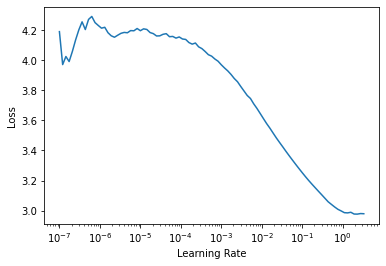

In [216]:
learn.lr_find()

In [128]:
learn.fit_one_cycle(12,1e-2, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.857718,1.574037,0.382325,00:33
1,1.823370,1.681125,0.337082,00:33
2,1.816924,1.706862,0.309856,00:34
3,1.799019,1.625510,0.347207,00:33
4,1.780002,1.635471,0.370041,00:33
5,1.774129,1.795522,0.269919,00:33
6,1.764802,1.538599,0.371566,00:34
7,1.756899,1.663107,0.331971,00:33
8,1.747747,1.551610,0.395060,00:34
9,1.739023,1.464783,0.411552,00:34


In [129]:
learn.save('res_model2.pth')

Path('models/res_model2.pth.pth')

In [132]:
learn.load('res_model2.pth')

stem = nn.Sequential(*list(learn.model.layers.children())[:-1])
#stem = nn.Sequential(*list(ResnetModel(10).layers.children())[:-1])
reg_m = ResnetRegression(stem, 6*16)
learn2 = Learner(dls_reg, reg_m, loss_func=my_mse_loss, metrics=AccumMetric(rmspe), wd=.1)

In [133]:
bx,by=dls_reg.one_batch()
out = reg_m.cuda()(bx)
F.mse_loss(out, by), my_mse_loss(out, by)

(tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(17.7015, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
learn2.fine_tune(8, 1e-2,freeze_epochs=3)

epoch,train_loss,valid_loss,rmspe,time
0,0.499282,0.301358,0.342196,00:32
1,0.389735,0.523112,0.555908,00:32
2,0.299998,0.215434,0.290670,00:33


epoch,train_loss,valid_loss,rmspe,time
0,0.260270,0.289486,0.329177,00:32
1,0.237639,0.361064,0.404368,00:32
2,0.225010,0.213695,0.267148,00:32
3,0.215401,0.225640,0.285212,00:32
4,0.208668,0.207343,0.259162,00:32


In [59]:
torch.save(learn2.model, 'res249.pth')

In [58]:
preds, targs = learn2.get_preds()

rmspe(preds.view(-1), targs)

tensor(0.2498)

In [36]:
preds, targs = learn.get_preds()

In [37]:
predicted_bins = torch.argmax(preds, dim=1)

In [38]:
CI = ClassificationInterpretation.from_learner(learn)

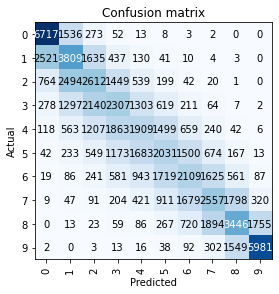

In [39]:
CI.plot_confusion_matrix()

In [40]:
pred_vals =torch.tensor(bin_med)[predicted_bins]

In [41]:
target_vals = dls.valid.items.target.to_numpy()
target_vals = torch.tensor(target_vals)

In [42]:
pred_vals[:10], target_vals[:10]

(tensor([0.0039, 0.0020, 0.0016, 0.0024, 0.0039, 0.0028, 0.0020, 0.0095, 0.0039,
         0.0047], dtype=torch.float64),
 tensor([0.0037, 0.0018, 0.0021, 0.0021, 0.0040, 0.0032, 0.0030, 0.0135, 0.0037,
         0.0054], dtype=torch.float64))

In [43]:
rmspe(pred_vals, target_vals)

tensor(0.2995, dtype=torch.float64)